# Hands-on Deep Learning for Organic solar cell

## *Using deep learning to estimate Bandgap of organic polymer and PCE of organic solar cell*

## Dataset:
The Clean Energy Project is run by Professor Alán Aspuru-Guzik and his team from the Department of Chemistry and Chemical Biology at Harvard University. They are looking to identify suitable compounds for organic electronic applications and harvesting renewable energy from the sun.
    The HCEP dataset contains properties for over 2.4 million compounds, derived from density functional theory calculations. Properties in this dataset include principle energy levels, photovoltaic performance parameters, mass and stoichiometric formulas

The composition will be specified as SMILES strings, which are a convenient way to represent the structure of organic materials. You can learn more about SMILES strings [here](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system). We will use these SMILES strings as inputs to a [convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network) and predict the Bandgap/PCE of organic materials. We will also learn how to train [variational autoencoders](https://www.jeremyjordan.me/variational-autoencoders/) to learn SMILES string representations. Variational autoencoders are models used to learn low-dimensional representations of a high-dimensional dataset, and in our case these models will give us a low-dimensional numerical representation of a SMILES string, which can replace the sparse matrices often used to represent data when using convolutional neural networks.


### Outline of this notebook:
#### _Load and pre-process training data_ 
- Load HCEP dataset containing many organic molecules 
- Pre-process data and split to test/train sets

#### _Train a Convolutional neural network (CNN)_ 
- Train a CNN to predict Bandgap/PCE
- Predict Bandgap/PCE from any given SMILES representation of a molecule 

In [ ]:
# pip install --upgrade google-api-python-client

In [1]:
import tensorflow as tf

C:\Users\prate\anaconda3\envs\my-rdkit-env1\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\prate\anaconda3\envs\my-rdkit-env1\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\prate\anaconda3\envs\my-rdkit-env1\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
import pandas as pd
# read dataset as a dataframe
dataset = pd.read_csv("huang_data.csv")

# print column names in dataset
print(f"Columns in dataset: {list(dataset.columns)}")

# print number of rows in dataset
print(f"\nLength of dataset: {len(dataset)}")

# shuffle rows of the dataset (we could do this later as well when doing train/test splits)
dataset = dataset.sample(frac=1, random_state=42)

# show first 5 rows of dataframe
dataset.head(10)

Columns in dataset: ['PCE_max', 'Voc ', 'Jsc ', 'FF', 'HOMO ', 'LUMO ', 'Bandgap', 'Eloss', 'Nickname', 'smiles']

Length of dataset: 1203


,PCE_max,Voc,Jsc,FF,HOMO,LUMO,Bandgap,Eloss,Nickname,smiles
1133,6.56,0.86,11.92,0.64,5.44,3.84,1.50,0.64,P1,CCCCCCCCCCC(CCCCCCCC)CN1C(=O)c2nc3c(nc2C1=O)c1...
425,3.64,0.87,7.62,0.55,5.33,2.72,1.85,0.98,PSB-TPTI (P3),CCCCCCCCC(CCCCCC)Cn1c(=O)c2cc3c(cc2c2sc(C)cc21...
78,0.36,0.37,2.46,0.40,4.56,2.59,1.97,1.60,H8,CCCCCCCCCCCCOc1c2cc(-c3sc(C)c4c3OCCO4)sc2c(OCC...
803,3.78,0.80,8.80,0.52,5.25,3.55,1.70,0.90,PBSTDTBT,CCCCCCCC[Si]1(CCCCCCCC)c2cc3c(cc2-c2sc(C)cc21)...
590,1.13,0.62,3.39,0.53,5.25,2.75,2.18,1.56,PBTCT,CCCCC(CC)COc1c2cc(-c3sc(C)c4c3CC(C(=O)OCC)(C(=...
908,0.31,0.70,1.17,0.38,5.17,3.83,1.34,0.64,CPDT-co-FATCN,CCCCCCC1(CCCCCC)c2cc(C)ccc2-c2ccc(N(c3ccc(/C=C...
881,2.80,0.54,11.90,0.44,4.81,3.08,1.43,0.89,PDTPBT-C5,CCCCCC(CCCCC)n1c2cc(C)sc2c2sc(-c3ccc(C)c4nsnc3...
543,2.40,0.66,8.30,0.44,5.29,3.73,1.56,0.90,PBDTSSBS,CCCCCCCCOc1c(OCCCCCCCC)c(-c2ccc(-c3cc4c(-c5ccc...
1195,2.22,0.54,8.00,0.51,5.11,3.69,1.42,0.88,PDTTDPP-EH,CCCCCCCCCCCCc1cc(C)sc1-c1cc2sc3cc(-c4sc(-c5ccc...
930,0.45,0.83,1.81,0.30,5.40,3.50,1.86,1.03,BDT-C6,CCCCCCc1cc2c(cc1CCCCCC)C(=O)c1c(-c3cc4c(OCC(CC...


In [3]:
# defining functions that will help in creating heatmaps


from typing import List, Optional
import numpy as np

def generate_charset(full_char_list:list) -> list:
    '''
    Assumes full_char_list is a list of characters (e.g., ['c', 'c', '1']).
    Returns a sorted list of unique characters, with index zero as a NULL character, and a PAD character.
    '''
    unique_chars = set(''.join(full_char_list))
    charset = ['NULL', 'PAD'] + sorted(unique_chars)
    return charset

def smiles_to_onehots(smiles_strings:list,
                     unique_charset:list,
                     max_smiles_chars:int) -> np.array:
    one_hots = []
    charset_length = len(unique_charset)

    for smiles_string in smiles_strings:
        one_hot_smiles = np.zeros(shape=(max_smiles_chars, charset_length))
        for i in range(max_smiles_chars):
            one_hot_col = [0]*charset_length
            ind = None # Which index will we flip to be "one-hot"?
            
            if i < len(smiles_string):
                try:
                    ind = unique_charset.index(smiles_string[i])
                    # one_hot_col[unique_charset.index(char)] = 1
                except ValueError:
                    ind = 0 # Treat as NULL if out-of-vocab  
                    # one_hot_col[0] = 1 # Treat as NULL if out-of-vocab   
            else:
                ind = 1 # Add PAD as needed
            
            one_hot_col[ind] = 1
            one_hot_smiles[i,:] = one_hot_col
            
        one_hots.append(one_hot_smiles)
    return np.array(one_hots)

C:\Users\prate\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PCE_max', ylabel='Density'>

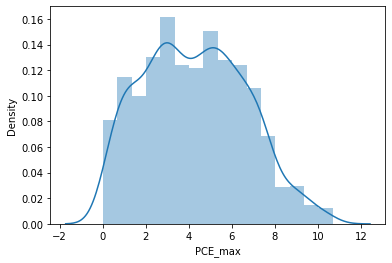

In [4]:
import seaborn as sns
sns.distplot(dataset["PCE_max"])

C:\Users\prate\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

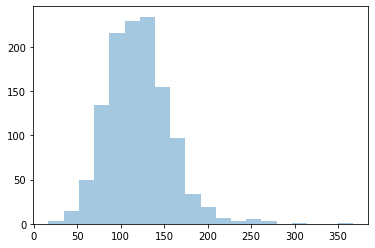

In [5]:
smiles_lengths = map(len, dataset.smiles.values)
sns.distplot(list(smiles_lengths), bins=20, kde=False)

In [6]:
# get unique character set in all SMILES strings 
charset = generate_charset(
    dataset["smiles"].values.ravel()
)

# get the number of unique characters
charset_length = len(charset)

# define max number of SMILES for model input vector
max_smiles_chars = 250

# dimension of input vector
input_dim = charset_length * max_smiles_chars

# get one-hot representation of the SMILES strings 
one_hots = smiles_to_onehots(dataset["smiles"].values, charset, max_smiles_chars)

# # split input into train and test sets
# X_train = one_hots[:-100]
# X_test = one_hots[-100:]

# # split output to train and test sets
output = dataset["PCE_max"].values
# Y_train = output[:-100]
# Y_test = output[-100:]
X = one_hots
Y = output

In [7]:
X.shape

(1203, 250, 41)

In [8]:
charset

['NULL',
 'PAD',
 '#',
 '%',
 '(',
 ')',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '=',
 '@',
 'B',
 'C',
 'F',
 'G',
 'H',
 'N',
 'O',
 'P',
 'S',
 '[',
 '\\',
 ']',
 'c',
 'e',
 'i',
 'l',
 'n',
 'o',
 's',
 't']

In [9]:
charset_length

41

CCCCCCCCCCCCc1c(C)sc2c1[P@](=O)(c1ccccc1)c1c-2sc(-c2cc3sc4c(-c5cc(CCCCCCCCCC)c(CCCCCCCCCC)s5)c5c(sc6cc(C)sc65)c(-c5cc(CCCCCCCCCC)c(CCCCCCCCCC)s5)c4c3s2)c1CCCCCCCCCCCC


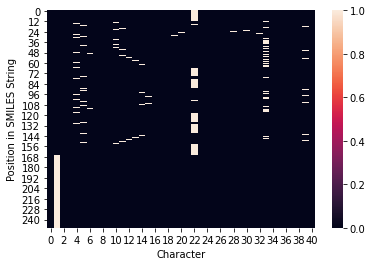

In [10]:
import matplotlib.pyplot as plt
index = 23
sns.heatmap(X[index]) # This is a single training example -- note that it is a matrix, not a single vector!
plt.xlabel('Character')
plt.ylabel('Position in SMILES String')
print(dataset.iloc[index]['smiles'])

Smiles string: PCzTTPz
Smiles string: CCCCCCCCc1cc2c3cc(CCCCCCCC)sc3c3nc4c(-c5ccc(-c6ccc7c8ccc(C)cc8n(C(CCCCCCCC)CCCCCCCC)c7c6)s5)ccc(-c5ccc(C)s5)c4nc3c2s1
PCE: 3.0
Bandgap 1.66


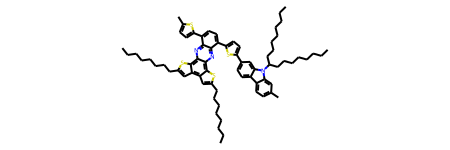

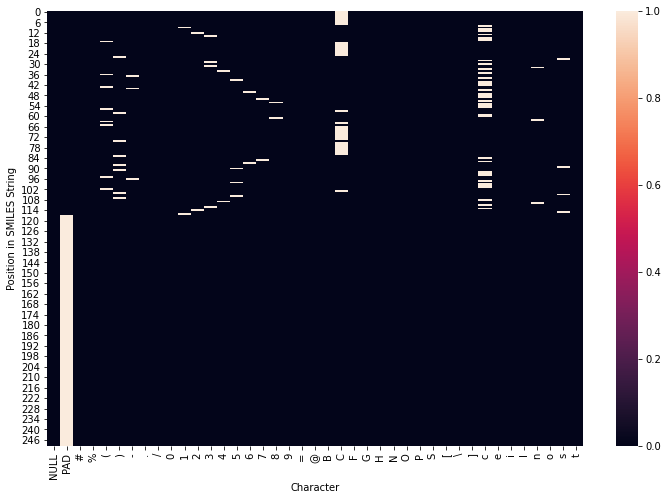

In [11]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
import matplotlib.pyplot as plt
index = 16
fig, ax = plt.subplots(figsize=(12,8))         # Sample figsize in inches
sns.heatmap(X[index],xticklabels=charset,ax=ax) # This is a single training example -- note that it is a matrix, not a single vector!
plt.xlabel('Character')
plt.ylabel('Position in SMILES String')
print('Smiles string:',dataset.iloc[index]['Nickname'])
print('Smiles string:',dataset.iloc[index]['smiles'])
print('PCE:',dataset.iloc[index]['PCE_max'])
print('Bandgap',dataset.iloc[index]['Bandgap'])
mol = Chem.MolFromSmiles(dataset.iloc[index]['smiles'])
mol

In [12]:
X=X.reshape(1203,250,41,1)

In [13]:
# from keras.models import Sequential
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=10)

In [14]:
from tensorflow.keras.layers import (Input, Dense, Conv1D, MaxPool1D, Dropout, GRU, LSTM, 
                          TimeDistributed, Add, Flatten, RepeatVector, Lambda, Concatenate)

In [15]:
from tensorflow.keras import datasets, layers, models
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu',padding="SAME",input_shape=(250, 41, 1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(32, (3, 3), activation='relu',padding="SAME"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.1))
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding="SAME"))
# model.add(layers.Conv2D(64, (3, 3), activation='relu',padding="SAME"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.1))
# model.add(layers.Conv2D(128, (3, 3), activation='relu',padding="SAME"))
# model.add(layers.Conv2D(128, (3, 3), activation='relu',padding="SAME"))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu',padding="SAME"))
# model.add(layers.Conv2D(128, (3, 3), activation='relu',padding="SAME"))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu',padding="SAME"))
# model.add(layers.Conv2D(128, (3, 3), activation='relu',padding="SAME"))
# # model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu',padding="SAME"))
# model.add(layers.Conv2D(128, (3, 3), activation='relu',padding="SAME"))
# model.add(layers.MaxPooling2D((2, 2)))


# model.add(layers.Conv2D(128, (3, 3), activation='relu'))



In [16]:
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.1))
# model.add(layers.Dense(32, activation='relu'))
# model.add(Dropout(0.1))
# model.add(layers.Dense(20, activation='relu'))
# model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(1))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 41, 32)       832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 20, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 125, 20, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 20, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 10, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 10, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 39680)             0

In [18]:
# from tensorflow import keras
# optimizer = keras.optimizers.Adam(learning_rate=0.0001)

In [19]:
model.compile(optimizer='adam',loss="mse",metrics='mae')
Model_rms_1=model.fit(x=X_train,y=y_train,epochs=100,batch_size=16,validation_split=0.1)

Epoch 1/100
61/61 [==============================] - 9s 17ms/step - loss: 7.2108 - mae: 2.1521 - val_loss: 6.0492 - val_mae: 2.0737
Epoch 2/100
61/61 [==============================] - 1s 11ms/step - loss: 5.3710 - mae: 1.9070 - val_loss: 5.7996 - val_mae: 2.0228
Epoch 3/100
61/61 [==============================] - 1s 11ms/step - loss: 5.1511 - mae: 1.8537 - val_loss: 5.8601 - val_mae: 2.0199
Epoch 4/100
61/61 [==============================] - 1s 11ms/step - loss: 4.6014 - mae: 1.7654 - val_loss: 5.0296 - val_mae: 1.8773
Epoch 5/100
61/61 [==============================] - 1s 11ms/step - loss: 4.0073 - mae: 1.6328 - val_loss: 5.2740 - val_mae: 1.8793
Epoch 6/100
61/61 [==============================] - 1s 11ms/step - loss: 3.7217 - mae: 1.5587 - val_loss: 5.8842 - val_mae: 1.9795
Epoch 7/100
61/61 [==============================] - 1s 11ms/step - loss: 3.1430 - mae: 1.4194 - val_loss: 5.4417 - val_mae: 1.8997
Epoch 8/100
61/61 [==============================] - 1s 11ms/step - loss: 2.

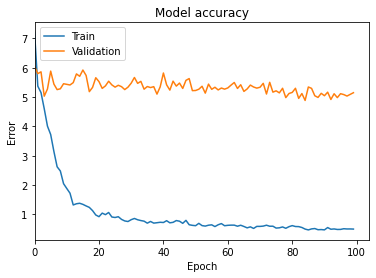

In [20]:
# plot the learning curve 
plt.plot(Model_rms_1.history['loss'])
plt.plot(Model_rms_1.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.xlim(0,)
plt.legend(['Train', 'Validation',], loc='upper left')
plt.show()

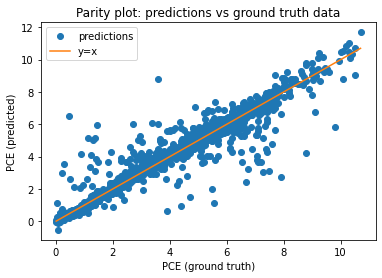

In [21]:
preds = model.predict(X_train)
x_y_line = np.linspace(min(y_train.flatten()), max(y_train.flatten()), 500)
plt.plot(y_train.flatten(), preds.flatten(), 'o', label='predictions')
plt.plot(x_y_line, x_y_line, label='y=x')
plt.xlabel("PCE (ground truth)")
plt.ylabel("PCE (predicted)")
plt.title("Parity plot: predictions vs ground truth data")
plt.legend()

In [22]:
from sklearn.metrics import r2_score
from sklearn import metrics

def R2Score(X,Y):
    r2=metrics.r2_score(X,Y)
    return r2

print('R2Score',R2Score(y_train, preds))

R2Score 0.8701837595733635


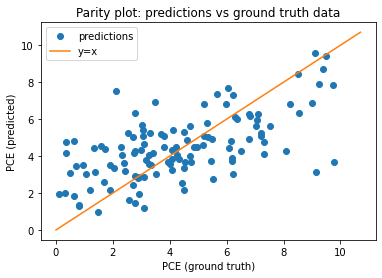

In [23]:
preds = model.predict(X_test)
x_y_line = np.linspace(min(y_train.flatten()), max(y_train.flatten()), 500)
plt.plot(y_test.flatten(), preds.flatten(), 'o', label='predictions')
plt.plot(x_y_line, x_y_line, label='y=x')
plt.xlabel("PCE (ground truth)")
plt.ylabel("PCE (predicted)")
plt.title("Parity plot: predictions vs ground truth data")
plt.legend()

In [24]:
from sklearn.metrics import r2_score
from sklearn import metrics

def R2Score(X,Y):
    r2=metrics.r2_score(X,Y)
    return r2

print('R2Score',R2Score(y_test, preds))

R2Score 0.36891385866401083


In [25]:
# Defining Metrics
def R2Score(X,Y):
    r2=metrics.r2_score(X,Y)
    return r2
def PearsonCoefficient(X, Y):
    corr, _ = pearsonr(X,Y)
    return corr
def MSE(X,Y):
    mse=mean_squared_error(X,Y)
    return mse
def RMSE(X,Y):
    rmse=np.sqrt(mean_squared_error(X,Y))
    return rmse
def MAPE(X,Y):
    mape=np.average(abs(np.array(X)-np.array(Y))/np.array(Y))*100
    return mape

In [26]:
from scipy.stats.stats import pearsonr

In [27]:
PearsonCoefficient(y_test, preds)

TypeError: No loop matching the specified signature and casting was found for ufunc add

In [31]:
from keras import initializers
init_weights = initializers.glorot_normal(seed=0)

In [32]:
# hidden activation layer
hidden_size = 32
dense_1_func = Dense(hidden_size, activation="relu", name="Fully-Connected-Latent", kernel_initializer=init_weights)

In [33]:
# VAE sampling
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal((batch, dim), mean=0.0, stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon # mu + sigma*epsilon yields a shifted, rescaled gaussian, 
                                                     # if epsilon is the standard gaussian

# encode to latent space
latent_dim = 41
z_mean_func = Dense(latent_dim, name='z_mean')
log_z_func = Dense(latent_dim, name='z_log_var')
z_func = Lambda(sampling, name='z_sample')

In [36]:
# this repeat vector just repeats the input `max_smiles_chars` times 
# so that we get a value for each character of the SMILES string
repeat_1_func = RepeatVector(max_smiles_chars, name="Repeat-Latent-1")

# RNN decoder
rnn_size = 41
gru_1_func = GRU(rnn_size, name="RNN-decoder-1", return_sequences=True, kernel_initializer=init_weights)
gru_2_func = GRU(rnn_size, name="RNN-decoder-2", return_sequences=True, kernel_initializer=init_weights)
gru_3_func = GRU(rnn_size, name="RNN-decoder-3", return_sequences=True, kernel_initializer=init_weights)

In [37]:
output_func = TimeDistributed(
    Dense(charset_length, activation="softmax", name="SMILES-Output", kernel_initializer=init_weights), 
    name="Time-Distributed"
)

In [38]:
# connecting the VAE model as a graph

# cnn encoder layers
conv_1_fwd = conv_1_func(smiles_input)
conv_2_fwd = conv_2_func(conv_1_fwd)
conv_3_fwd = conv_3_func(conv_2_fwd)
conv_4_fwd = conv_4_func(conv_3_fwd)

# flattening
flattened_convs = flatten_func(conv_4_fwd)
dense_1_fwd = dense_1_func(flattened_convs)

# latent space
z_mean = z_mean_func(dense_1_fwd)
z_log_var = log_z_func(dense_1_fwd)
z = z_func([z_mean, z_log_var])

# rnn decoder layers
repeat_1_fwd = repeat_1_func(z)
gru_1_fwd = gru_1_func(repeat_1_fwd)
gru_2_fwd = gru_2_func(gru_1_fwd)
gru_3_fwd = gru_3_func(gru_2_fwd)
smiles_output = output_func(gru_3_fwd)

NameError: name 'conv_1_func' is not defined